<a href="https://colab.research.google.com/github/j2nhyeok/self-study/blob/main/%EC%BD%94%ED%98%B8%ED%8A%B8_%EB%B6%84%EC%84%9D_%EC%98%88%EC%8B%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
from pandas import Series
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')



## 샘플 데이터 불러오기
df=pd.read_excel('https://github.com/springcoil/marsmodelling/blob/master/relay-foods.xlsx?raw=true',
                 sheet_name='Purchase Data - Full Study')
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2891 non-null   int64         
 1   OrderDate     2891 non-null   datetime64[ns]
 2   UserId        2891 non-null   int64         
 3   TotalCharges  2891 non-null   float64       
 4   CommonId      2891 non-null   object        
 5   PupId         2891 non-null   int64         
 6   PickupDate    2891 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 158.2+ KB


In [7]:
## 전처리 과정1. 필요 없는 Column들은 Pandas의 Drop Method를 활용

df = df.drop(['CommonId','PupId','PickupDate'],axis=1)


## 전처리 과정2. 우리는 월별 데이터가 목적이기 때문에 데이터 형식을 치환
df['OrderCycle']=df['OrderDate'].dt.strftime('%Y.%m')

## 샘플 데이터 뽑아서 확인해보기
df.sample(3)

,OrderId,OrderDate,UserId,TotalCharges,OrderCycle
2144,2085,2009-12-17,131626,79.79,2009.12
349,259,2009-01-06,1558,62.74,2009.01
2802,2767,2010-02-10,326850,26.22,2010.02


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2891 non-null   int64         
 1   OrderDate     2891 non-null   datetime64[ns]
 2   UserId        2891 non-null   int64         
 3   TotalCharges  2891 non-null   float64       
 4   OrderCycle    2891 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 113.1+ KB


In [14]:
first_order = df.groupby('UserId')['OrderDate'].min()
first_order = first_order.dt.strftime('%Y.%m')
first_order.sample(4)

UserId
101054    2009.10
319471    2010.02
89123     2009.10
6578      2009.04
Name: OrderDate, dtype: object

In [15]:
## Data Frame의 Index를 User Id로 일시적으로 전환
df = df.set_index('UserId')

## 데이터 First 데이터는 Series + DF는 pandas이기에 Index 기준 자동 병합가능
df['FirstOrder'] = first_order

## Index의 정상화
df.reset_index(inplace = True)

df.sample(3)

,UserId,OrderId,OrderDate,TotalCharges,OrderCycle,FirstOrder
445,3640,1596,2009-11-03,82.9000,2009.11,2009.01
69,47,2873,2010-02-16,79.9095,2010.02,2009.01
2534,231090,2497,2010-01-26,34.8500,2010.01,2010.01


In [17]:
## 주기별 구매 User 계산
co1 = df.groupby(['FirstOrder', 'OrderCycle']).UserId.nunique()
co1 = co1.reset_index()
co1.rename({'UserId': 'TotalUsers'}, axis = 1, inplace = True)

co1.head()

,FirstOrder,OrderCycle,TotalUsers
0,2009.01,2009.01,22
1,2009.01,2009.02,8
2,2009.01,2009.03,10
3,2009.01,2009.04,9
4,2009.01,2009.05,10


In [18]:
!pip install ipypb

In [19]:
from ipypb import ipb
temp = []

for i in ipb(range(co1.shape[0])):
    f_first_order = pd.to_datetime(co1.FirstOrder[i]).to_period('M')
    f_order_cycle = pd.to_datetime(co1.OrderCycle[i]).to_period('M')

    month_diff = (f_order_cycle - f_first_order).n

    temp.append(month_diff)

co1['CohortPeriod'] = temp


 [████████████████████████████████████████████████████████████] 119/119 [00:00<00:00, 0.00s/it]

In [21]:
co1.head()

,FirstOrder,OrderCycle,TotalUsers,CohortPeriod
0,2009.01,2009.01,22,0
1,2009.01,2009.02,8,1
2,2009.01,2009.03,10,2
3,2009.01,2009.04,9,3
4,2009.01,2009.05,10,4


In [23]:
co_retention = co1.set_index(['FirstOrder', 'CohortPeriod'])

In [26]:
co_retention.TotalUsers

FirstOrder  CohortPeriod
2009.01     0                22
            1                 8
            2                10
            3                 9
            4                10
                           ... 
2010.01     1                50
            2                26
2010.02     0               100
            1                19
2010.03     0                24
Name: TotalUsers, Length: 119, dtype: int64

In [33]:
co_retention = co_retention.TotalUsers.unstack(1)

In [37]:
retention = co_retention.div(co_retention[0], axis=0)
retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
FirstOrder,,,,,,,,,,,,,,,
2009.01,1.0,0.363636,0.454545,0.409091,0.454545,0.363636,0.363636,0.318182,0.318182,0.318182,0.318182,0.363636,0.500000,0.318182,0.272727
2009.02,1.0,0.200000,0.333333,0.066667,0.266667,0.266667,0.266667,0.333333,0.333333,0.266667,0.200000,0.200000,0.333333,NaN,NaN
2009.03,1.0,0.307692,0.384615,0.307692,0.076923,0.153846,0.153846,0.230769,0.153846,0.076923,0.230769,0.153846,0.076923,NaN,NaN
2009.04,1.0,0.333333,0.256410,0.333333,0.153846,0.179487,0.102564,0.153846,0.051282,0.102564,0.076923,0.051282,NaN,NaN,NaN
2009.05,1.0,0.260000,0.240000,0.100000,0.080000,0.120000,0.060000,0.100000,0.100000,0.080000,0.060000,NaN,NaN,NaN,NaN
2009.06,1.0,0.468750,0.281250,0.187500,0.218750,0.156250,0.093750,0.093750,0.312500,0.093750,NaN,NaN,NaN,NaN,NaN
2009.07,1.0,0.460000,0.260000,0.200000,0.220000,0.200000,0.220000,0.140000,0.140000,NaN,NaN,NaN,NaN,NaN,NaN
2009.08,1.0,0.354839,0.290323,0.225806,0.193548,0.258065,0.129032,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009.09,1.0,0.405405,0.378378,0.216216,0.351351,0.243243,0.216216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


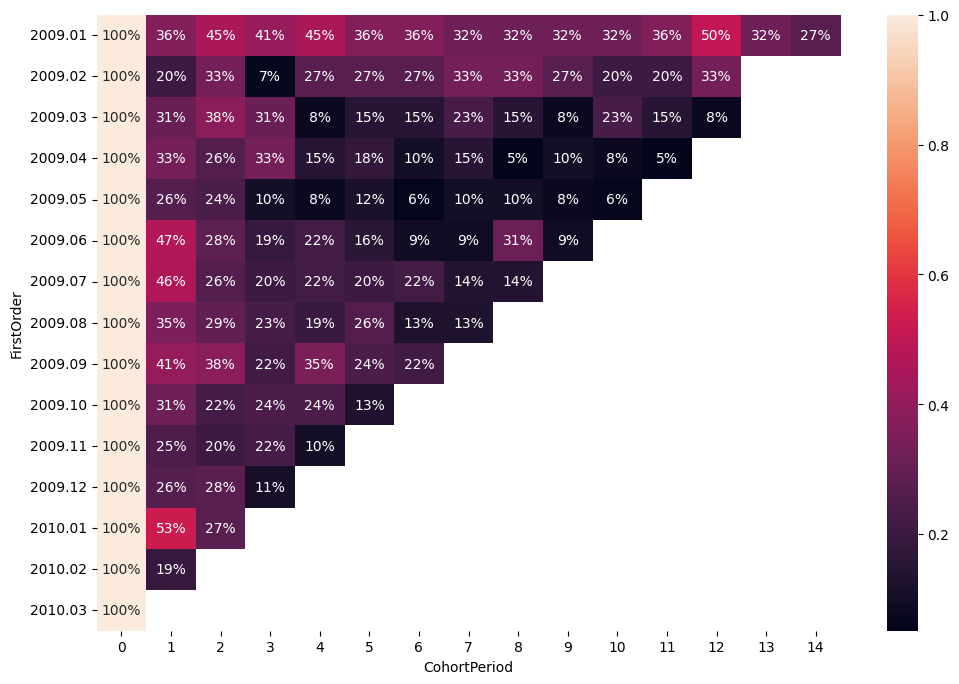

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 8)
sns.heatmap(retention, annot = True, fmt = '.0%')

plt.yticks(rotation = 360);